In [1]:
"""
This is our 2-stage testing script (binary and multiclass)

Author: Wesley
"""
import numpy as np
import pandas as pd
import pickle
import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [2]:
"""
This is a custom transformer that allows us to reduce the feature sets for each classifier appropriately.

Necessary since we're making them all part of a StackingClassifier and each one uses a different feature set.
"""
class FeatureReducer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_list=None):
        self.feature_list = feature_list
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        if self.feature_list is None:
            return X
        
        else:
            return X.loc[:, self.feature_list]

Load dataset and get binary and multiclass y columns.

In [3]:
binary_train = pd.read_csv("binary_train.csv")
binary_test = pd.read_csv("binary_test.csv")

multiclass_train = pd.read_csv("multiclass_train.csv")
multiclass_test = pd.read_csv("multiclass_test.csv")

print(binary_train[" Label"].value_counts())
print(binary_test[" Label"].value_counts())
print(multiclass_train[" Label"].value_counts())
print(multiclass_test[" Label"].value_counts())

BENIGN     74190
TFTP        6184
UDP         6184
NetBIOS     6183
SSDP        6183
SNMP        6183
NTP         6183
Portmap     6183
DNS         6183
LDAP        6183
MSSQL       6183
UDP-lag     6183
Syn         6183
Name:  Label, dtype: int64
BENIGN     18548
UDP-lag     1546
MSSQL       1546
LDAP        1546
Syn         1546
Portmap     1546
NTP         1546
SSDP        1546
DNS         1546
SNMP        1546
NetBIOS     1546
TFTP        1545
UDP         1545
Name:  Label, dtype: int64
TFTP       12366
MSSQL      12366
DNS        12366
LDAP       12366
Syn        12366
Portmap    12366
UDP        12366
NTP        12365
UDP-lag    12365
SSDP       12365
NetBIOS    12365
SNMP       12365
Name:  Label, dtype: int64
UDP-lag    3092
SSDP       3092
SNMP       3092
NTP        3092
NetBIOS    3092
Portmap    3091
TFTP       3091
DNS        3091
Syn        3091
LDAP       3091
MSSQL      3091
UDP        3091
Name:  Label, dtype: int64


Split and encode data.

In [4]:
bin_y_train = binary_train[" Label"].copy()
bin_x_train = binary_train.drop([" Label"], axis=1)

bin_y_test = binary_test[" Label"].copy()
bin_x_test = binary_test.drop([" Label"], axis=1)

bin_y_train = [0 if x=="BENIGN" else 1 for x in bin_y_train.values]
bin_y_test = [0 if x=="BENIGN" else 1 for x in bin_y_test.values]

print("The text labels from the encoding will be passed to classification report so we can interpret our results more easily.\n")
binary_labels = ["BENIGN", "ATTACK"]

print("Binary Label Encodings (in order of digits 0 -> 1): ")
print(binary_labels)

multi_y_train = multiclass_train[" Label"].copy()
multi_x_train = multiclass_train.drop([" Label"], axis=1)

multi_y_test = multiclass_test[" Label"].copy()
multi_x_test = multiclass_test.drop([" Label"], axis=1)

# Encode attack labels to int and save as array to be used later.
le = LabelEncoder()

multi_y_train = le.fit_transform(multi_y_train.values)
multi_y_test = le.transform(multi_y_test.values)

multiclass_labels = []
print("\nMulticlass Label Encodings (in order of digits 0 -> n): ")
for i in range(0, len(list(set(list(multi_y_test))))):
    multiclass_labels.append(le.inverse_transform([i])[0])

print(multiclass_labels)

The text labels from the encoding will be passed to classification report so we can interpret our results more easily.

Binary Label Encodings (in order of digits 0 -> 1): 
['BENIGN', 'ATTACK']

Multiclass Label Encodings (in order of digits 0 -> n): 
['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


Load models

In [5]:
feature_sets = pickle.load(open("feature_sets.pickle", 'rb'))

In [6]:
# Load a binary model
stage_1 = make_pipeline(FeatureReducer(), RandomForestClassifier(random_state=42, criterion = 'entropy', max_depth = 100, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 7, n_estimators = 344))

# Use the custom transformer to reduce the feature sets for each classifier appropriately.
clf_knn = make_pipeline(FeatureReducer(feature_list = feature_sets["Multiclass"]["Mutual Information"]), KNeighborsClassifier(algorithm = 'ball_tree', n_neighbors = 7, weights =  'distance'))
clf_dt = make_pipeline(FeatureReducer(feature_list = feature_sets["Multiclass"]["RFE Sets"]["Decision Tree"]), DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth = 18, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 10))
clf_lr = make_pipeline(FeatureReducer(feature_list = feature_sets["Multiclass"]["RFE Sets"]["Logistic Regression"]), StandardScaler(), LogisticRegression(C = 9972.476141278883, max_iter =  483, random_state=42))
clf_rf = make_pipeline(FeatureReducer(feature_list = feature_sets["Multiclass"]["RFE Sets"]["Random Forest"]), RandomForestClassifier(random_state=42, criterion = 'entropy', max_depth = 19, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 14, n_estimators = 452))

# Load the estimators into a list.
estimators = [("knn",clf_knn),("dt",clf_dt),("lr",clf_lr),("rf",clf_rf)]

# Intialize the stacking classifier (finally)
stage_2 = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))

Stage 1 Prediction (Binary)

In [7]:
#scal = StandardScaler()
#bin_x_train_reshaped = scal.fit_transform(bin_x_train)
#bin_x_test_reshaped = scal.transform(bin_x_test)
stage_1.fit(bin_x_train, bin_y_train)
y_pred = stage_1.predict(bin_x_test)
#y_pred = [1 if x>=0.5 else 0 for x in y_pred]

In [8]:
print(classification_report(bin_y_test, y_pred, digits=6, target_names=binary_labels))

              precision    recall  f1-score   support

      BENIGN   0.999030  0.999892  0.999461     18548
      ATTACK   0.999892  0.999030  0.999461     18550

    accuracy                       0.999461     37098
   macro avg   0.999461  0.999461  0.999461     37098
weighted avg   0.999461  0.999461  0.999461     37098



Housekeeping to prepare the dataset for 2nd stage.

In [9]:
# Create new dataframe out of binary predictions and multiclass labels that can be used to compare them later.
X_agg = bin_x_test.copy()
X_agg["binary_pred"] = y_pred.copy()
X_agg[" Label"] = binary_test[" Label"].copy()
#X_agg[" Label"] = le.transform(X_agg[" Label"].values)
X_agg.loc[~X_agg[" Label"].isin(le.classes_)," Label"] = -1 
X_agg.loc[X_agg[" Label"].isin(le.classes_)," Label"] = le.transform(X_agg[" Label"][X_agg[" Label"].isin(le.classes_)])

# Slice out the portions that we've identified as benign and replace their label with that of the multiclass benign label for comparison later.
X_rem = X_agg[X_agg["binary_pred"] == 0]
X_rem['binary_pred'] = X_rem['binary_pred'].replace([0], -1)

# Slice out the portions we've labeled as attack for 2nd stage classification.
X_mult = X_agg[X_agg["binary_pred"] == 1]
X_mult = X_mult.drop(["binary_pred"], axis = 1)
y_mult = X_mult[" Label"].values.copy()

X_mult = X_mult.drop([" Label"], axis = 1)

C:\Users\icarus\AppData\Local\Temp\ipykernel_84268\2310080828.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rem['binary_pred'] = X_rem['binary_pred'].replace([0], -1)


2nd stage prediction

In [10]:
# Fit the stacking classifier
stage_2.fit(multi_x_train, multi_y_train)

y_pred2 = stage_2.predict(X_mult)

c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [11]:
print(np.unique(y_pred2, return_counts=True))
print(np.unique(list(y_mult), return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([1224, 1836, 1581, 1533, 1487, 1662, 1547, 1605, 1505, 1540, 1542,
       1472], dtype=int64))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([   2, 1542, 1543, 1545, 1544, 1545, 1546, 1542, 1546, 1545, 1545,
       1545, 1544], dtype=int64))


In [12]:
print(multiclass_labels)
multiclass_labels_add = ["BENIGN"]
multiclass_labels_add.extend(multiclass_labels)
print(multiclass_labels_add)

['DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']
['BENIGN', 'DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDP-lag']


In [13]:
print(classification_report(list(y_mult), y_pred2, digits=6, target_names=multiclass_labels_add))

              precision    recall  f1-score   support

      BENIGN   0.000000  0.000000  0.000000         2
         DNS   0.770425  0.611543  0.681851      1542
        LDAP   0.734205  0.873623  0.797869      1543
       MSSQL   0.850095  0.869903  0.859885      1545
         NTP   0.994781  0.987694  0.991225      1544
     NetBIOS   0.851379  0.819417  0.835092      1545
     Portmap   0.924188  0.993532  0.957606      1546
        SNMP   0.835165  0.837873  0.836517      1542
        SSDP   0.547664  0.568564  0.557918      1546
         Syn   0.986047  0.960518  0.973115      1545
        TFTP   1.000000  0.996764  0.998379      1545
         UDP   0.533722  0.532686  0.533204      1545
     UDP-lag   0.880435  0.839378  0.859416      1544

    accuracy                       0.824215     18534
   macro avg   0.762162  0.760884  0.760160     18534
weighted avg   0.825582  0.824215  0.823423     18534



c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\icarus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Final Calculation of Results

In [14]:
y_pred_final = list(X_rem["binary_pred"].values.copy())
y_pred_final.extend(y_pred2)

y_true_final = list(X_rem[" Label"].values.copy())
y_true_final.extend(list(y_mult))

print(classification_report(y_true_final, y_pred_final, digits=6, target_names=multiclass_labels_add))

              precision    recall  f1-score   support

      BENIGN   0.999030  0.999892  0.999461     18548
         DNS   0.770425  0.609961  0.680866      1546
        LDAP   0.734205  0.871928  0.797161      1546
       MSSQL   0.850095  0.869340  0.859610      1546
         NTP   0.994781  0.986417  0.990581      1546
     NetBIOS   0.851379  0.818887  0.834817      1546
     Portmap   0.924188  0.993532  0.957606      1546
        SNMP   0.835165  0.835705  0.835435      1546
        SSDP   0.547664  0.568564  0.557918      1546
         Syn   0.986047  0.959897  0.972796      1546
        TFTP   1.000000  0.996764  0.998379      1545
         UDP   0.533722  0.532686  0.533204      1545
     UDP-lag   0.880435  0.838292  0.858847      1546

    accuracy                       0.911693     37098
   macro avg   0.839010  0.837067  0.836668     37098
weighted avg   0.912351  0.911693  0.911280     37098



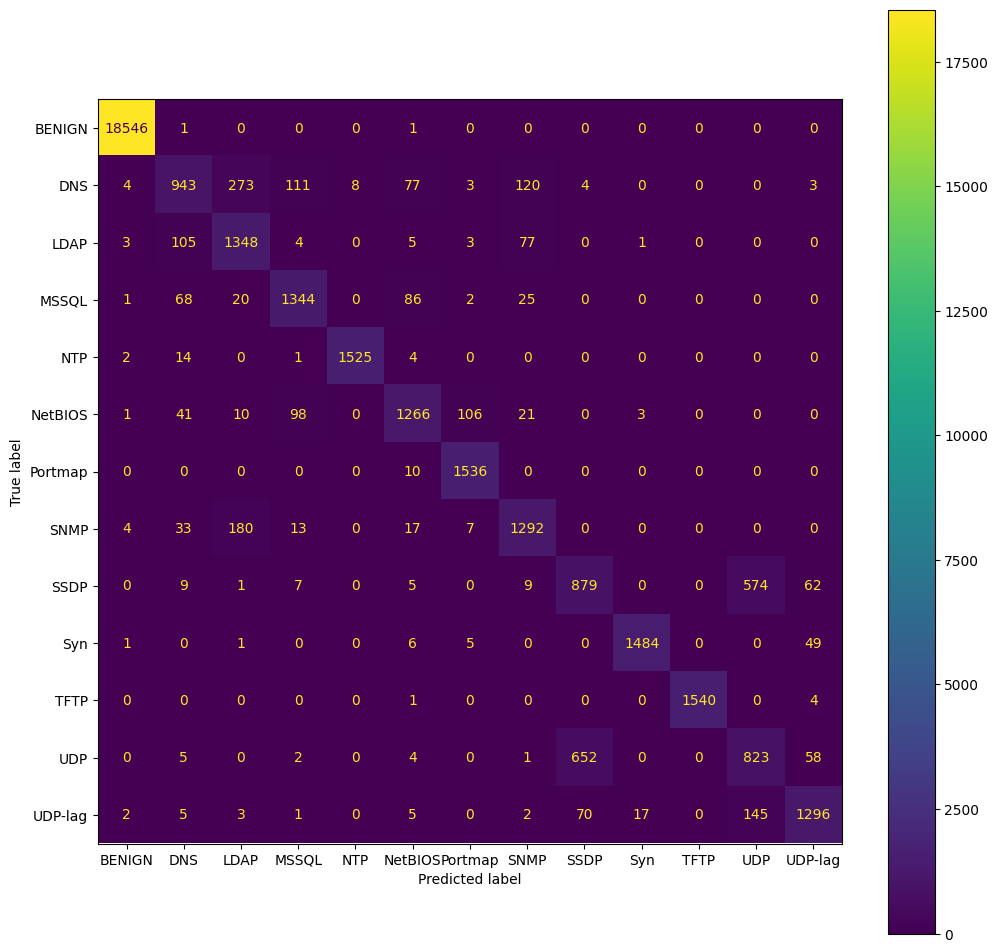

In [16]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_final, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels_add)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.savefig("confusion_2stage.png")